## Deep ANN
In this notebook we will implement a Deep ANN from scratch in python.

In [126]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) 

In [127]:
#Utility functions
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z 
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)  
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [128]:
#Function to initialize parameters of a deep neural network
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
    return parameters

In [146]:
#Implement linear forward step
def linear_forward(A, W, b):
    Z = np.matmul(W,A)+b
    cache = (A, W, b)
    return Z, cache

In [147]:
#Implement linear forward with activation
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

In [182]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                 
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)],"relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)],"sigmoid")
    caches.append(cache) 
    return AL, caches

In [183]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL),Y)+np.multiply(np.log(1-AL),(1-Y)))/m
    cost = np.squeeze(cost)     
    return cost

In [184]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m * np.matmul(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.matmul(W.T, dZ)
    return dA_prev, dW, db

In [185]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)   
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [186]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
   
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [187]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [230]:
layers_dims = [10, 5, 1] 

In [237]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []                        
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [238]:
def predict(X, y, parameters):    
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))

    probas, caches = L_model_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))    
    return p


In [239]:
#Make hastie dataset
from sklearn.datasets import make_hastie_10_2
N = 10000
(X,y) = make_hastie_10_2(n_samples=N)
y = (y+1)/2
y = y.astype(int)

In [240]:
#Do test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(f"X_train shape={X_train.shape}")
print(f"X_test shape={X_test.shape}")
print(f"y_train shape={y_train.shape}")
print(f"y_test shape={y_test.shape}")

X_train shape=(7500, 10)
X_test shape=(2500, 10)
y_train shape=(7500, 1)
y_test shape=(2500, 1)


Cost after iteration 0: 0.693080
Cost after iteration 100: 0.692970
Cost after iteration 200: 0.692750
Cost after iteration 300: 0.692279
Cost after iteration 400: 0.691256
Cost after iteration 500: 0.689093
Cost after iteration 600: 0.684867
Cost after iteration 700: 0.677416
Cost after iteration 800: 0.665813
Cost after iteration 900: 0.649846
Cost after iteration 1000: 0.630790
Cost after iteration 1100: 0.610691
Cost after iteration 1200: 0.591639
Cost after iteration 1300: 0.575120
Cost after iteration 1400: 0.561980
Cost after iteration 1500: 0.552264
Cost after iteration 1600: 0.545431
Cost after iteration 1700: 0.540592
Cost after iteration 1800: 0.537224
Cost after iteration 1900: 0.534794
Cost after iteration 2000: 0.532945
Cost after iteration 2100: 0.531557
Cost after iteration 2200: 0.530537
Cost after iteration 2300: 0.529690
Cost after iteration 2400: 0.529051
Cost after iteration 2500: 0.528518
Cost after iteration 2600: 0.528030
Cost after iteration 2700: 0.527642
Cost

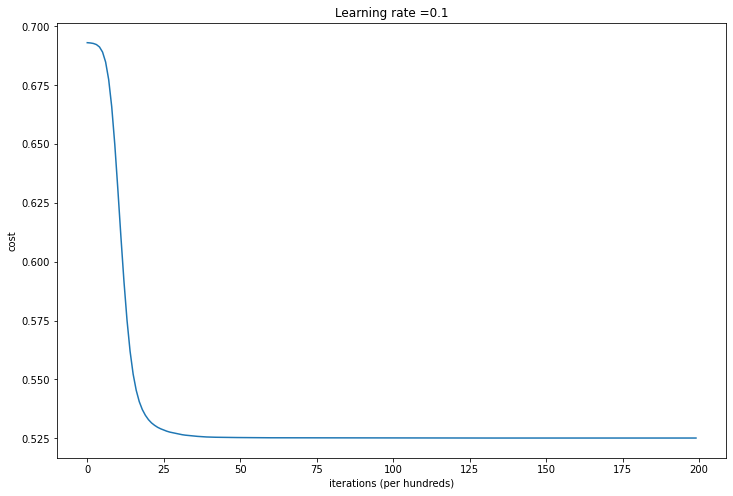

In [241]:
parameters = L_layer_model(X_train.T, y_train.T, layers_dims, num_iterations = 20000, print_cost = True)

In [242]:
pred_train = predict(X_train.T, y_train.T, parameters)

Accuracy: 0.7328000000000002


In [243]:
pred_test = predict(X_test.T, y_test.T, parameters)

Accuracy: 0.6976000000000001


This model seems to be under parametrized. It does give a descent accuracy but a bigger model can give better results.